In [1]:
import os
import tqdm

from scipy.sparse import load_npz
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.6.0')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [10]:
import numpy as np
import pickle
import os
import json
import random


in_path = "../data/game_features.npz"
ds = load_npz(in_path)

# in_path = "/media/ooki/sstorage/bk/data/tsetlin_dota_1_skill3.pkl"

# with open(in_path, "rb") as fp:
#     ds = pickle.load(fp)
    
# print("loaded {} games from: {}".format(len(ds), in_path))


# in_path22 = "/media/ooki/sstorage/bk/data/tsetlin_dota_22_skill3.pkl"
# with open(in_path22, "rb") as fp:
#     ds22 = pickle.load(fp)
#     ds.extend(ds22)

# print("loaded {} games from: {}".format(len(ds22), in_path22))
# ds22 = None

print("shuffle")
random.seed(42)
# random.shuffle(ds)
print("<done>")

shuffle
<done>


In [11]:
ds.todense()

MemoryError: Unable to allocate 24.8 GiB for an array with shape (1877341, 14161) and data type int8

In [5]:
from collections import Counter, defaultdict

def get_key(g):
    t0, t1 = g[0][0], g[0][1]

    t0.sort()
    t1.sort()
    if t0[0][0] > t1[0][0]:
        t0, t1 = t1, t0

    keys = [p[0] for p in t0]
    keys.extend([p[0] for p in t1])
    return tuple(keys)


u_ds = defaultdict(list)
i_ds = Counter()

for g in tqdm.tqdm(ds):
    key = get_key(g)
    u_ds[key].append(g)
    i_ds[key] += 1
    



0it [00:00, ?it/s]


IndexError: row index (1) out of range

In [4]:

print("pre: ", len(ds))
print("post:", len(u_ds))

most_common = i_ds.most_common(10)[5][0]

for g in u_ds[most_common]:
    print("winner:", g[1])
    print("team0:", g[0][0])
    print("team1:", g[0][1])    
    print("-"*50)


new_ds = []
for gl in u_ds.values():
    new_ds.append(gl[0])
    
print("new ds:", len(new_ds))
del ds
del u_ds
del i_ds
ds = new_ds


pre:  3606066
post: 2728231
winner: 1
team0: [(21, 485), (47, 407), (79, 234), (86, 220), (114, 440)]
team1: [(6, 732), (19, 445), (27, 365), (28, 456), (128, 550)]
--------------------------------------------------
winner: 1
team0: [(21, 485), (47, 407), (79, 234), (86, 220), (114, 440)]
team1: [(6, 732), (19, 445), (27, 365), (28, 456), (128, 550)]
--------------------------------------------------
new ds: 2728231


In [5]:
def get_ex(g):
    n = 130
    
    t0, t1 = g[0][0], g[0][1]
    w = g[1]
    
    if random.random() > 0.5:
        t0, t1 = t1, t0
        w = (w + 1) % 2
        
    f = np.zeros(n, dtype=np.int8)
        
    for h in t0:
        f[h[0]] = 1
    
    for h in t1[0:2]:
        f[h[0]] = -1
        
    return f, w
        
def get_ds_set(games):
    train_x = []
    train_y = []
    for g in tqdm.tqdm(games):
        x, y = get_ex(g)
        train_x.append(x)
        train_y.append(y)
        
    return np.array(train_x), np.array(train_y)

n_train_size = 1900000
n_test_size = 100000

x_train, y_train = get_ds_set(ds[0:n_train_size])
x_test, y_test = get_ds_set(ds[-n_test_size:])
print("train:", x_train.shape)
print("test:", x_test.shape)

100%|██████████| 100000/100000 [00:00<00:00, 474351.26it/s]

train: (1900000, 130)
test: (100000, 130)


In [10]:
from sklearn.linear_model import LogisticRegression


lreg = LogisticRegression(fit_intercept=False)
lreg.fit(x_train, y_train)

print("train acc:", lreg.score(x_train, y_train))
print("test acc:", lreg.score(x_test, y_test))

train acc: 0.5655163157894737
test acc: 0.55863


In [11]:

prior_weights = torch.tensor(lreg.coef_, dtype=torch.float32)
print("prior_weights:", prior_weights.shape)

lreg.coef_.min()

prior_weights: torch.Size([1, 130])


-0.5198663872287452

In [32]:
from torch import nn
import pyro
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro.distributions as dist

n_features = 130

class BayesianLogisticRegression(PyroModule):
    def __init__(self, in_features, out_features, prior_weights=0.0, prior_std=3.0):
        super().__init__()
        
        self.linear = PyroModule[nn.Linear](in_features, out_features, bias=False).cuda()
        self.linear.weight = PyroSample(dist.Normal(prior_weights, prior_std).expand([out_features, in_features]).to_event(2))
        
        #self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        self.sigmoid = nn.Sigmoid()
        
        self.did_print = False

    def forward(self, x, y=None):
        mean = self.linear(x).squeeze(-1)
        model_logits = self.sigmoid(mean)            
                        
        with pyro.plate("data", x.shape[0]):                        
            if self.did_print is False:
                self.did_print = True
                print("plate data: ", x.shape)
            
            if y is not None:
                y = y.squeeze()
                
            obs = pyro.sample("obs", dist.Bernoulli(model_logits), obs=y)
            
        return model_logits
    
  

In [34]:
import torch
from pyro.infer import SVI, Trace_ELBO

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

from torch.utils.data import DataLoader, TensorDataset

use_cuda = True


n_features = x_train.shape[1]
model = BayesianLogisticRegression(n_features, 1)
guide = AutoDiagonalNormal(model)

#guide = AutoMultivariateNormal(model) #, init_loc_fn=init_to_mean)

#print("model:", model.is_cuda)




svi = SVI(model,
          guide,
          #pyro.optim.Adam({"lr": 0.0001}),
          pyro.optim.SGD({"lr": 0.001}),
          loss=Trace_ELBO())

pyro.clear_param_store()

num_iterations = 15

lreg_tester = LogisticRegression(fit_intercept=False)
lreg_tester.fit(x_train[0:3], y_train[0:3])


x_data = torch.tensor(x_train, dtype=torch.float32)
y_data = torch.tensor(y_train, dtype=torch.float32)
#x_data
tensor_ds = TensorDataset(x_data.float(), y_data.float())
data_loader = DataLoader(tensor_ds, batch_size=10000, shuffle=True)


for j in tqdm.tqdm(range(num_iterations)):
    # calculate the loss and take a gradient step
    total_loss = 0.0
    for batch_x, batch_y in data_loader:
        loss = svi.step(batch_x, batch_y)
        total_loss += loss
        
    if j % 5 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, total_loss / x_data.shape[0]))
        
        with torch.no_grad():
            posterior_coef = list(guide.parameters())[0].view(1, -1).numpy()
            
        lreg_tester.coef_ = posterior_coef
        train_score = lreg_tester.score(x_train, y_train).item()
        test_score = lreg_tester.score(x_test, y_test).item()
        print("\t train: {:.3f},  test:{:.3f}".format(train_score, test_score))



  0%|          | 0/15 [00:00<?, ?it/s]

plate data:  torch.Size([10000, 130])
[iteration 0001] loss: 0.7428


  7%|▋         | 1/15 [00:16<03:55, 16.85s/it]

	 train: 0.562,  test:0.556


 33%|███▎      | 5/15 [01:48<03:41, 22.12s/it]

[iteration 0006] loss: 0.7235


 40%|████      | 6/15 [02:04<03:02, 20.28s/it]

	 train: 0.563,  test:0.556


 67%|██████▋   | 10/15 [03:36<01:50, 22.09s/it]

[iteration 0011] loss: 0.7226


 73%|███████▎  | 11/15 [04:01<01:31, 22.98s/it]

	 train: 0.563,  test:0.555


100%|██████████| 15/15 [05:24<00:00, 21.66s/it]


In [35]:
with torch.no_grad():
    for name, value in pyro.get_param_store().items():
        print(name, pyro.param(name).size())
        
    posterior_w = list(guide.parameters())[0].view(1, -1).numpy()
    print("posterior_w:", posterior_w.shape)
    
lreg_tester.coef_ = posterior_w
train_score = lreg_tester.score(x_train, y_train).item()
test_score = lreg_tester.score(x_test, y_test).item()
print("\t train: {:.3f},  test:{:.3f}".format(train_score, test_score))

      

AutoDiagonalNormal.loc torch.Size([130])
AutoDiagonalNormal.scale torch.Size([130])
posterior_w: (1, 130)
	 train: 0.563,  test:0.558


In [37]:
from pyro.infer import Predictive


n_new_points = 500000
n_samples_per_game = 500

model.cpu()
guide.cpu()
predictive = Predictive(model, guide=guide, num_samples=n_samples_per_game, return_sites=("_RETURN",))


new_data = []
for k in tqdm.tqdm(range(n_new_points)):
    x = x_train[k]
    y = y_train[k]    
    
    x = torch.FloatTensor(x_test[k])
    with torch.no_grad():
        v = predictive(x)["_RETURN"]
        
    m = torch.mean(v, 0).item()
    std = torch.std(v, 0).item()
    lower = v.kthvalue(int(len(v) * 0.05), dim=0)[0].item()
    upper = v.kthvalue(int(len(v) * 0.95), dim=0)[0].item()
    med = v.kthvalue(int(len(v) * 0.50), dim=0)[0].item()                
    label = y.item()
    
    d = {"x": x_test[k], "mean": m, "std": std, "lower": lower, "upper": upper, "median": med, "winner": label}
    
    new_data.append(d)
    
print("<done: {} examples made>".format(len(new_data)))



 20%|██        | 100000/500000 [6:14:36<24:58:26,  4.45it/s]


IndexError: index 100000 is out of bounds for axis 0 with size 100000

In [38]:
preds = [d["mean"] > 0.5 for d in new_data]
labels = [d["winner"] for d in new_data]
acc = (np.array(preds) == labels).mean()
print("total acc:", acc)


def is_advantage(g):
    if g["lower"] > 0.5:
        return True
    
    if g["upper"] < 0.5:
        return True
        
    return False    

clear_data = list(filter(is_advantage, new_data))
print("#new_data:", len(new_data))
print("#clear_data:", len(clear_data))

preds = [d["mean"] > 0.5 for d in clear_data]
labels = [d["winner"] for d in clear_data]
acc = (np.array(preds) == labels).mean()
print("[CLEAN] total acc:", acc)

total acc: 0.5009
#new_data: 100000
#clear_data: 28784
[CLEAN] total acc: 0.5064271817676487


acc: 0.4507


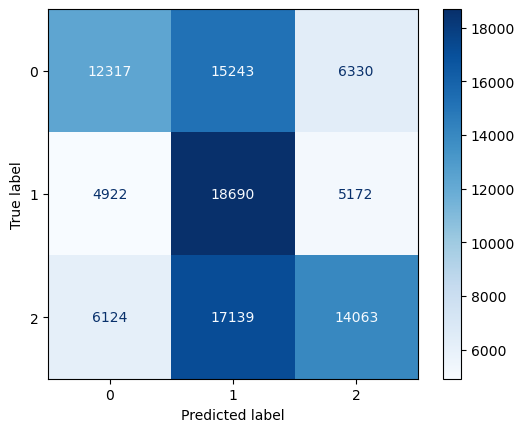

In [39]:
from sklearn.naive_bayes import GaussianNB


def get_label(g):
    if is_advantage(g):
        return 1
    elif g["mean"] < 0.5:
        return 0
    else:
        return 2

three_data_x = np.array([d["x"] for d in new_data])
three_data_y = np.array([get_label(d) for d in new_data], dtype=int)


nb_clf = GaussianNB()
nb_clf.fit(three_data_x, three_data_y)
nb_clf.score(three_data_x, three_data_y)

import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

                    
disp = plot_confusion_matrix(nb_clf, three_data_x, three_data_y.reshape(-1, 1),                                 
                                 cmap=plt.cm.Blues)

print("acc:", nb_clf.score(three_data_x, three_data_y))


In [ ]:
means = [d["mean"] for d in new_data]
sns.distplot(np.array(means), kde=True, hist=True, hist_kws={"range": [0,1]})


In [ ]:
import pickle
data_out = "/home/ooki/tsetlin_data/dota3_{}k.pkl".format(int(len(new_data) // 1000))

with open(data_out, "wb") as fp:
    pickle.dump(new_data, fp, protocol=pickle.HIGHEST_PROTOCOL)

print("wrote [{}] to: {}".format(len(new_data), data_out))

